In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

import fna
import warnings

warnings.filterwarnings('ignore') # warnings are for the weak

sys.path.append("../../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files
sys.path.append("../../") # we need this to successfully read pickle files

import pipeline as pipeline


In [2]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'MGN']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

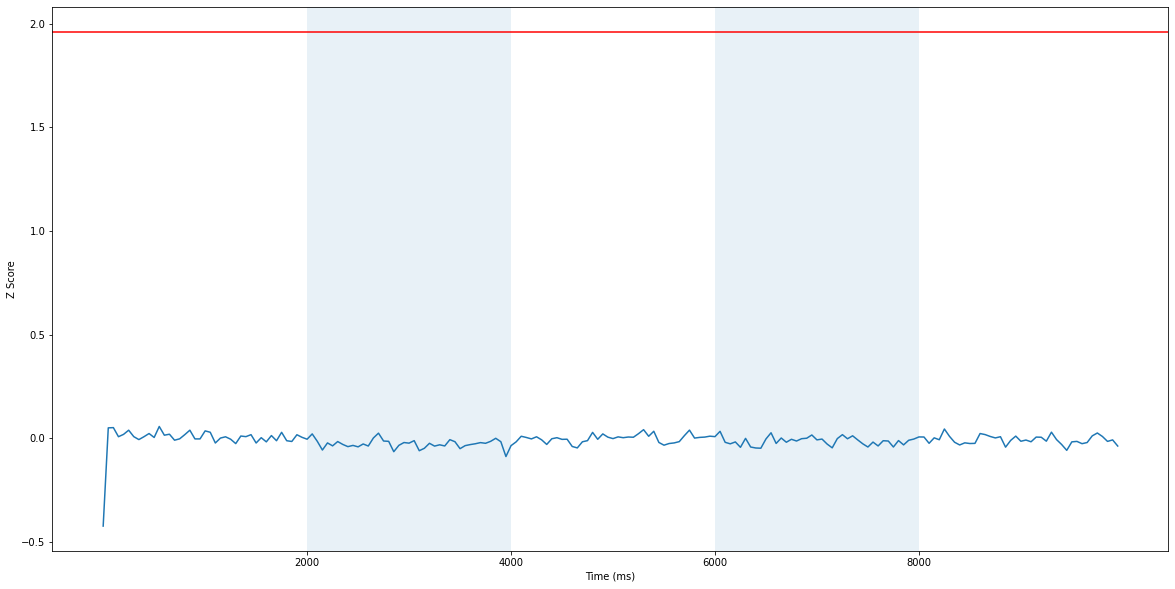

In [28]:
pth = "../../demyelination/data/splasticity-cadist-reload/activity/"
f = ['spk_splasticity-cadist-reload_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 50

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 10)

ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1);
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1);

ax.plot(z_scores)

ax.set_xticks([40, 80, 120, 160], [2000, 4000, 6000, 8000]);

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");

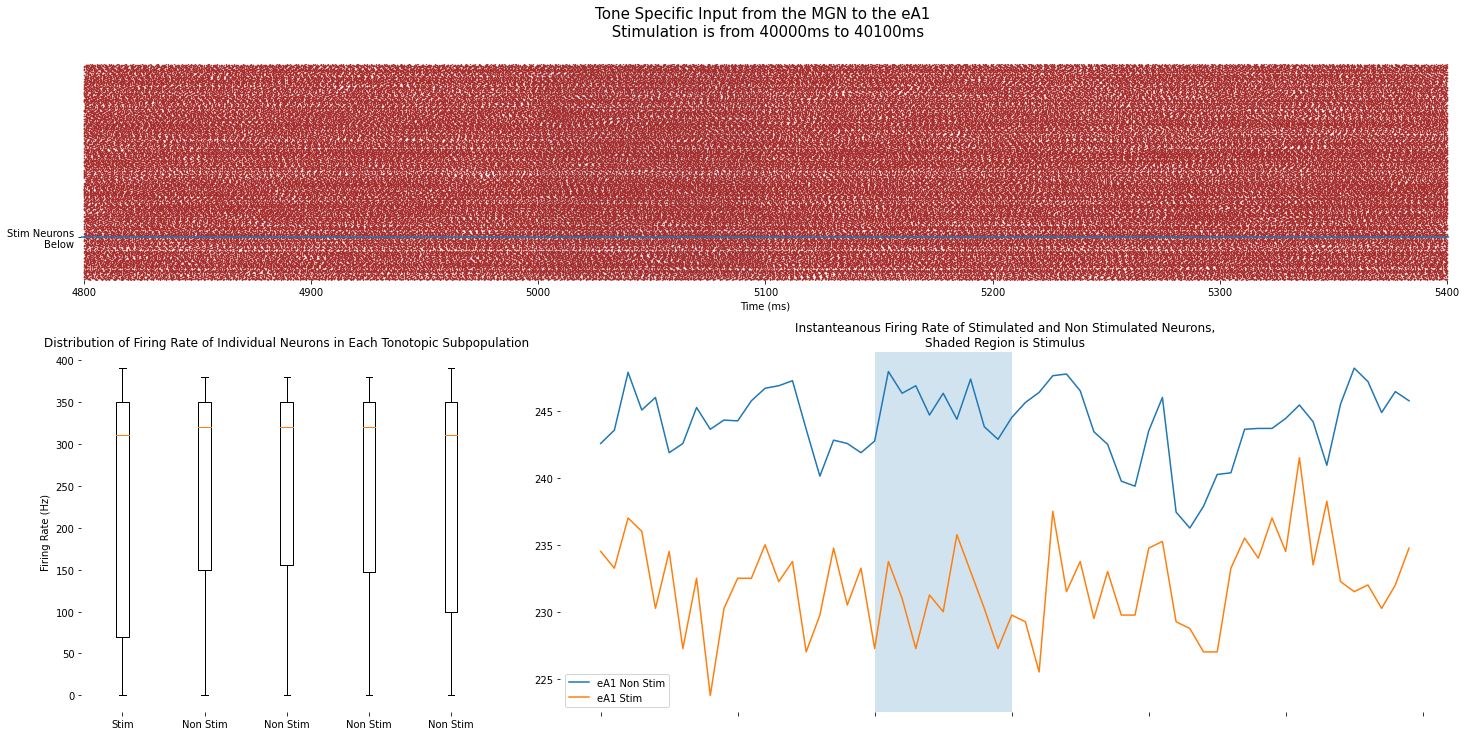

In [29]:
fig = plt.figure()
fig.set_size_inches((19, 10))

# BOX WHISKER PLOT
ax = fig.add_axes([0, 0, .3, .5], frameon=False)
tstart, tstop = 5000, 5100
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(801, 2400)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Non Stim", log=True);
# ax.hist(p.spikeobj['eA1'].id_slice(np.arange(401, 800)).time_slice(tstart, tstop).mean_rates()\
#               , density=True, alpha=0.3, label="eA1 Stim", log=True);
for x in range(1, 6):
    nstart = (400*x)+1
    ax.boxplot(p.spikeobj['eA1'].id_slice(np.arange(nstart, nstart+400)).time_slice(tstart, tstop).mean_rates(),
              positions=[x], sym="")
# ax.legend()
ax.set_ylabel("Firing Rate (Hz)")
ax.set_xticks(range(1, 6), ["Stim", "Non Stim", "Non Stim", "Non Stim", "Non Stim"])
ax.set_title("Distribution of Firing Rate of Individual Neurons in Each Tonotopic Subpopulation")

tstart, tstop = 4800, 5400

# INST FIRING RATE PLOT
ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(801, 2401)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Non Stim")
ax.plot(\
p.spikeobj['eA1'].id_slice(np.arange(401, 801)).time_slice(tstart, tstop).firing_rate(10, average=True)
        , label="eA1 Stim")
ax.legend()
ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
ax.tick_params(labelbottom=False)
ax.axvspan(20, 30, alpha=.2)

# # MGN INST FIRING RATE PLOT
# ax = fig.add_axes([.35, 0, .65, .5], frameon=False)
# ax.plot(\
# p.spikeobj['MGN'].id_slice(np.arange(41, 201)).time_slice(tstart, tstop).firing_rate(10, average=True)
#         , label="MGN Non Stim")
# ax.plot(\
# p.spikeobj['MGN'].id_slice(np.arange(1, 41)).time_slice(tstart, tstop).firing_rate(10, average=True)
#         , label="MGN Stim")
# ax.legend()
# ax.set_title("Instanteanous Firing Rate of Stimulated and Non Stimulated Neurons,\nShaded Region is Stimulus")
# ax.tick_params(labelbottom=False)
# ax.axvspan(20, 30, alpha=.2)

# RASTER PLOT
ax = fig.add_axes([0, .6, 1, .3], frameon=False)
p.spikeobj['eA1'].time_slice(tstart, tstop).raster_plot(ax=ax, dt=10, display=False, color='brown', ms=1)
ax.axvspan(5000, 5100, alpha=.1)

ax.set_frame_on(False)
# ax.tick_params(labelbottom=False)
ax.set_xlabel("Time (ms)")

ax.set_yticks([800], ['Stim Neurons\nBelow'])

ax.axhline(800)

fig.suptitle("Tone Specific Input from the MGN to the eA1 \n Stimulation is from 40000ms to 40100ms", fontsize=15);


# plt.savefig("/home/pbr-student/Downloads/thesis-plots/tonostim-comparison-eaone.jpg")

In [19]:
for population in ['MGN', 'TRN', 'eA1', 'iA1']:
    for criterion in ['cerina', 'mit']:
        spk_train = p.spikeobj[population].time_slice(1000, 2000)
        br = pipeline.computePopulationBurstSpikeRatio(spk_train, criterion)
        print(population, criterion, np.mean(br))

MGN cerina 0.0
MGN mit 1.668402430902431
TRN cerina 27.1518161413493
TRN mit 17.046982158130273
eA1 cerina 7.179715996383264
eA1 mit 4.61352950389154
iA1 cerina 13.533374763651736
iA1 mit 9.559504973348787


In [30]:
for population in ['MGN', 'TRN', 'eA1', 'iA1']:
    print(p.spikeobj[population].time_slice(1000, 2000).mean_rate())

3.56
66.55
242.0755
86.85
